In [ ]:
# Based on notebook from https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [1]:
#!python -m pip install torchinfo
import torchinfo
from tqdm.auto import tqdm

/Users/matiasmolinolo/anaconda3/envs/iag/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [3]:
# create a transofrm to apply to each datapoint
transform = transforms.ToTensor()  # transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = "~/datasets"
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device(
    "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)

In [4]:
device

device(type='cpu')

In [5]:
# get a batch of images
dataiter = iter(train_loader)
batch_images = next(dataiter)

In [6]:
batch_images[0].shape

torch.Size([100, 1, 28, 28])

In [7]:
# flatten batch
flatten_batch = batch_images[0].view(batch_size, 1 * 28 * 28).to(device)
flatten_batch.shape

torch.Size([100, 784])

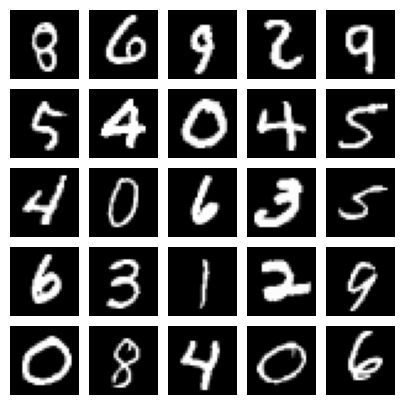

In [8]:
# get 25 sample training images for visualization
num_samples = 25
sample_images = [batch_images[0][i, 0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap="gray")
    ax.axis("off")

plt.show()

In [9]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, z_dim=2):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2),
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, z_dim)
        self.logvar_layer = nn.Linear(latent_dim, z_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, sdev):
        epsilon = torch.randn_like(sdev)
        z = mean + sdev * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        sdev = torch.exp(0.5 * logvar)  # sdev = sqrt(var)
        z = self.reparameterization(mean, sdev)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [10]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [11]:
torchinfo.summary(
    model, input_size=(100, 784), col_names=("input_size", "output_size", "num_params")
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
VAE                                      [100, 784]                [100, 784]                --
├─Sequential: 1-1                        [100, 784]                [100, 200]                --
│    └─Linear: 2-1                       [100, 784]                [100, 400]                314,000
│    └─LeakyReLU: 2-2                    [100, 400]                [100, 400]                --
│    └─Linear: 2-3                       [100, 400]                [100, 200]                80,200
│    └─LeakyReLU: 2-4                    [100, 200]                [100, 200]                --
├─Linear: 1-2                            [100, 200]                [100, 2]                  402
├─Linear: 1-3                            [100, 200]                [100, 2]                  402
├─Sequential: 1-4                        [100, 2]                  [100, 784]                --
│    └─Linear: 2-5      

In [12]:
def loss_function(x, x_hat, mean, logvar):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return reproduction_loss + KLD

In [13]:
def train(model, optimizer, epochs, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(tqdm(train_loader)):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var).to(device)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print(
            "\tEpoch",
            epoch + 1,
            "\tAverage Loss: ",
            overall_loss / (batch_idx * batch_size),
        )
    return overall_loss

In [14]:
train(model.to(device), optimizer, epochs=25)

100%|██████████| 600/600 [00:09<00:00, 61.02it/s]


	Epoch 1 	Average Loss:  179.21993423283598


100%|██████████| 600/600 [00:09<00:00, 62.53it/s]


	Epoch 2 	Average Loss:  160.09022037053944


100%|██████████| 600/600 [00:10<00:00, 58.25it/s]


	Epoch 3 	Average Loss:  156.1133372189326


100%|██████████| 600/600 [00:10<00:00, 54.68it/s]


	Epoch 4 	Average Loss:  153.76939149885226


100%|██████████| 600/600 [00:11<00:00, 53.22it/s]


	Epoch 5 	Average Loss:  152.25667042727463


100%|██████████| 600/600 [00:13<00:00, 44.86it/s]


	Epoch 6 	Average Loss:  150.91668002986748


100%|██████████| 600/600 [00:10<00:00, 56.38it/s]


	Epoch 7 	Average Loss:  149.86240570221202


100%|██████████| 600/600 [00:09<00:00, 62.87it/s]


	Epoch 8 	Average Loss:  148.8806043927379


100%|██████████| 600/600 [00:12<00:00, 47.35it/s]


	Epoch 9 	Average Loss:  148.19744073781823


100%|██████████| 600/600 [00:12<00:00, 48.86it/s]


	Epoch 10 	Average Loss:  147.54258348875732


100%|██████████| 600/600 [00:11<00:00, 50.94it/s]


	Epoch 11 	Average Loss:  146.97447086289648


100%|██████████| 600/600 [00:10<00:00, 55.65it/s]


	Epoch 12 	Average Loss:  146.49847069334308


100%|██████████| 600/600 [00:10<00:00, 55.33it/s]


	Epoch 13 	Average Loss:  146.11864953959724


100%|██████████| 600/600 [00:11<00:00, 53.48it/s]


	Epoch 14 	Average Loss:  145.68773300553005


100%|██████████| 600/600 [00:11<00:00, 53.76it/s]


	Epoch 15 	Average Loss:  145.350759583029


100%|██████████| 600/600 [00:10<00:00, 56.17it/s]


	Epoch 16 	Average Loss:  144.9285925435622


100%|██████████| 600/600 [00:11<00:00, 54.08it/s]


	Epoch 17 	Average Loss:  144.53427714811144


100%|██████████| 600/600 [00:10<00:00, 54.60it/s]


	Epoch 18 	Average Loss:  144.35133984701065


100%|██████████| 600/600 [00:11<00:00, 52.26it/s]


	Epoch 19 	Average Loss:  143.91205224853923


100%|██████████| 600/600 [00:11<00:00, 51.31it/s]


	Epoch 20 	Average Loss:  143.66453635290588


100%|██████████| 600/600 [00:10<00:00, 54.60it/s]


	Epoch 21 	Average Loss:  143.53047867865715


100%|██████████| 600/600 [00:11<00:00, 50.23it/s]


	Epoch 22 	Average Loss:  143.2407374269616


100%|██████████| 600/600 [00:11<00:00, 54.16it/s]


	Epoch 23 	Average Loss:  143.1148598249687


100%|██████████| 600/600 [00:11<00:00, 53.19it/s]


	Epoch 24 	Average Loss:  142.70920631064794


100%|██████████| 600/600 [00:11<00:00, 53.56it/s]

	Epoch 25 	Average Loss:  142.46142979184057


8533439.64453125

In [15]:
torch.save(model, 'vae.pt')

In [16]:
def generate_digit(z_dim=2):
    z_sample = torch.randn(size=(1, z_dim)).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)  # reshape vector to 2d array
    plt.title(f"[{z_sample[0,0]},{z_sample[0,1]}]")
    plt.imshow(digit, cmap="gray")
    plt.axis("off")
    plt.show()

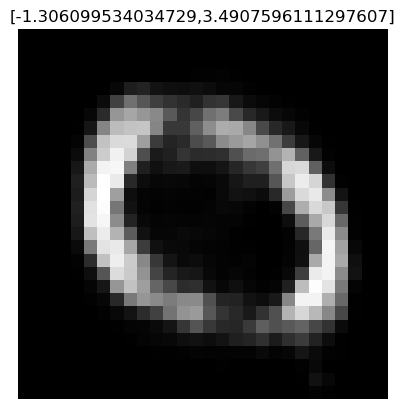

In [17]:
generate_digit()

In [18]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title("VAE Latent Space Visualization")
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

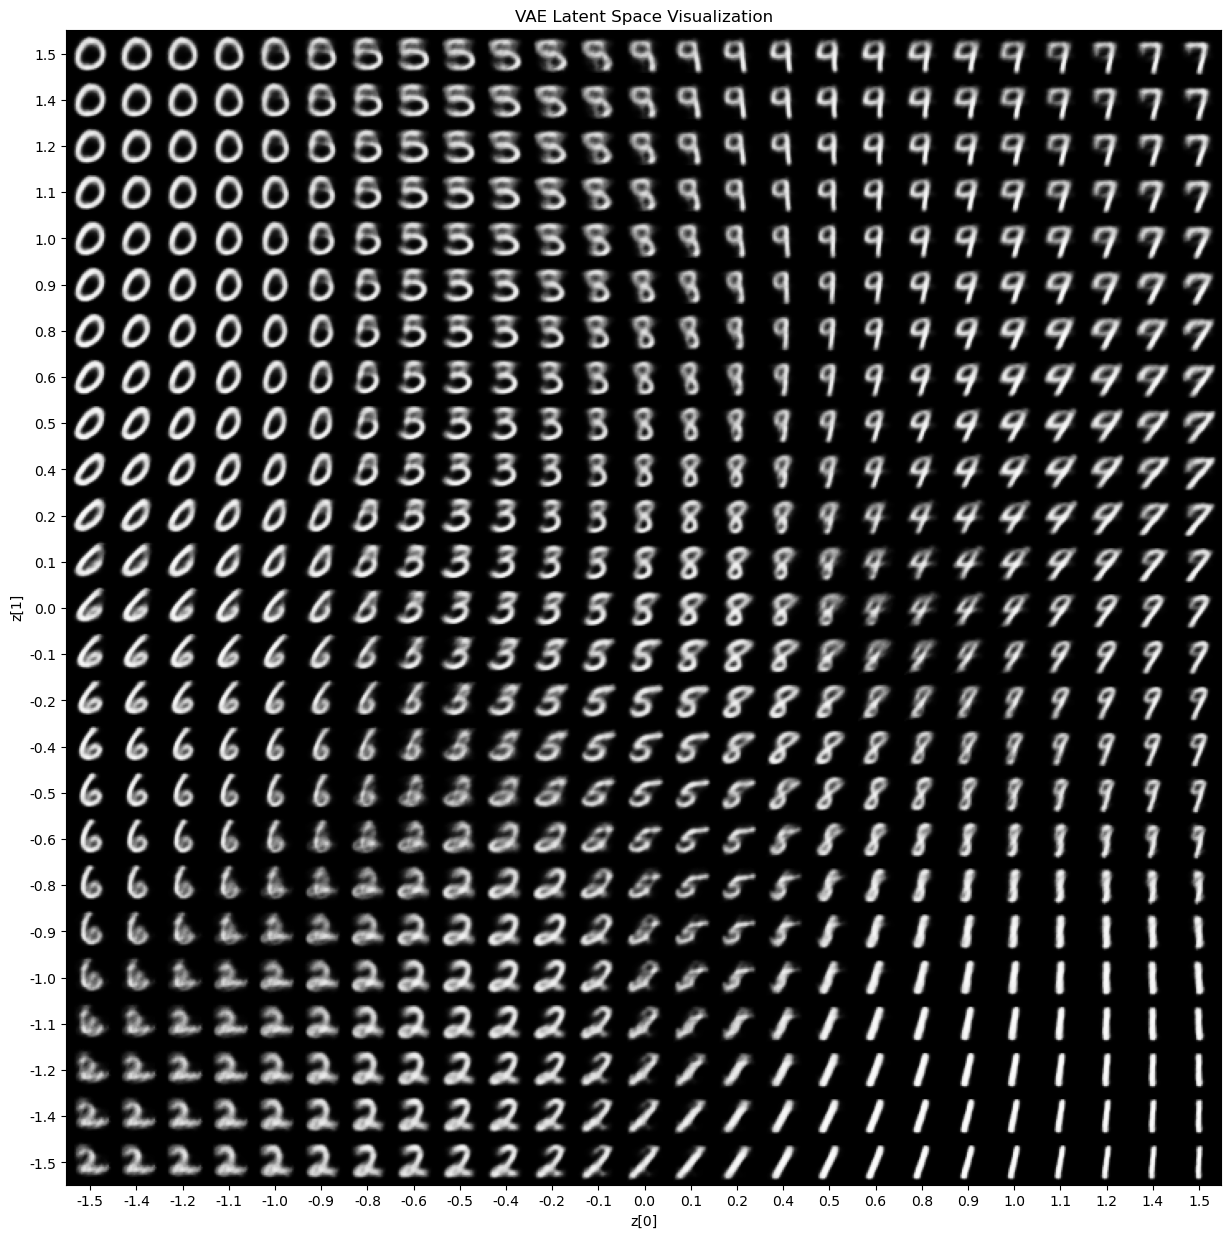

In [19]:
plot_latent_space(model, scale=1.5)

In [20]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, z_dim=2):
        super(ConditionalVAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2),
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, z_dim)
        self.logvar_layer = nn.Linear(latent_dim, z_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(z_dim + 1, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    def encode(self, x, y):
        x = self.encoder(torch.cat([x, y], dim=1))
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, sdev):
        epsilon = torch.randn_like(sdev)
        z = mean + sdev * epsilon
        return z

    def decode(self, x, y):
        return self.decoder(torch.cat([x, y], dim=1))

    def forward(self, x, y):
        mean, logvar = self.encode(x, y)
        sdev = torch.exp(0.5 * logvar)  # sdev = sqrt(var)
        z = self.reparameterization(mean, sdev)
        x_hat = self.decode(z, y)
        return x_hat, mean, logvar

In [23]:
model_cond = ConditionalVAE().to(device)
optimizer_cond = Adam(model_cond.parameters(), lr=1e-3)

In [24]:
def train_conditional(model, optimizer, epochs, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, y) in enumerate(tqdm(train_loader)):
            x = x.view(batch_size, x_dim).to(device)
            y = torch.unsqueeze(y, 1).to(device)
            optimizer.zero_grad()

            x_hat, mean, log_var = model(x, y)
            loss = loss_function(x, x_hat, mean, log_var).to(device)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print(
            "\tEpoch",
            epoch + 1,
            "\tAverage Loss: ",
            overall_loss / (batch_idx * batch_size),
        )
    return overall_loss

In [25]:
train_conditional(model_cond.to(device), optimizer_cond, epochs=25)

100%|██████████| 600/600 [00:10<00:00, 59.99it/s]


	Epoch 1 	Average Loss:  175.15364001852046


100%|██████████| 600/600 [00:09<00:00, 60.54it/s]


	Epoch 2 	Average Loss:  152.44930885786206


100%|██████████| 600/600 [00:11<00:00, 53.21it/s]


	Epoch 3 	Average Loss:  147.39077388094742


100%|██████████| 600/600 [00:12<00:00, 47.16it/s]


	Epoch 4 	Average Loss:  144.7656025015651


100%|██████████| 600/600 [00:14<00:00, 42.10it/s]


	Epoch 5 	Average Loss:  142.9664031523894


100%|██████████| 600/600 [00:13<00:00, 43.85it/s]


	Epoch 6 	Average Loss:  141.69529812056552


100%|██████████| 600/600 [00:14<00:00, 41.00it/s]


	Epoch 7 	Average Loss:  140.64186454964002


100%|██████████| 600/600 [00:13<00:00, 45.72it/s]


	Epoch 8 	Average Loss:  139.85681785723602


100%|██████████| 600/600 [00:13<00:00, 44.45it/s]


	Epoch 9 	Average Loss:  139.16391965124166


100%|██████████| 600/600 [00:13<00:00, 44.43it/s]


	Epoch 10 	Average Loss:  138.5484344023894


100%|██████████| 600/600 [00:12<00:00, 46.88it/s]


	Epoch 11 	Average Loss:  137.99389961459204


100%|██████████| 600/600 [00:12<00:00, 46.41it/s]


	Epoch 12 	Average Loss:  137.5769890898894


100%|██████████| 600/600 [00:11<00:00, 50.30it/s]


	Epoch 13 	Average Loss:  137.1129824610027


100%|██████████| 600/600 [00:12<00:00, 49.03it/s]


	Epoch 14 	Average Loss:  136.75572508542885


100%|██████████| 600/600 [00:12<00:00, 49.62it/s]


	Epoch 15 	Average Loss:  136.39803825059997


100%|██████████| 600/600 [00:11<00:00, 50.79it/s]


	Epoch 16 	Average Loss:  136.03010626434684


100%|██████████| 600/600 [00:11<00:00, 50.75it/s]


	Epoch 17 	Average Loss:  135.7969203881469


100%|██████████| 600/600 [00:12<00:00, 48.05it/s]


	Epoch 18 	Average Loss:  135.568214569856


100%|██████████| 600/600 [00:12<00:00, 49.63it/s]


	Epoch 19 	Average Loss:  135.3161245793771


100%|██████████| 600/600 [00:13<00:00, 45.70it/s]


	Epoch 20 	Average Loss:  135.0533190245461


100%|██████████| 600/600 [00:13<00:00, 45.31it/s]


	Epoch 21 	Average Loss:  134.92062847258453


100%|██████████| 600/600 [00:14<00:00, 41.91it/s]


	Epoch 22 	Average Loss:  134.6766020352932


100%|██████████| 600/600 [00:15<00:00, 39.71it/s]


	Epoch 23 	Average Loss:  134.43133319529946


100%|██████████| 600/600 [00:14<00:00, 42.52it/s]


	Epoch 24 	Average Loss:  134.32305893937814


100%|██████████| 600/600 [00:14<00:00, 42.10it/s]

	Epoch 25 	Average Loss:  134.1371739031198


8034816.716796875

In [26]:
torch.save(model_cond, 'cvae.pt')

In [27]:
def generate_digit_cond(digit_class, z_dim=2):
    z_sample = torch.randn(size=(1, z_dim)).to(device)
    z_class_sample = torch.unsqueeze(torch.tensor([digit_class]), dim=1).to(device)
    x_decoded = model_cond.decode(z_sample, z_class_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)  # reshape vector to 2d array
    plt.title(f"[{z_sample[0,0]},{z_sample[0,1]}]")
    plt.imshow(digit, cmap="gray")
    plt.axis("off")
    plt.show()

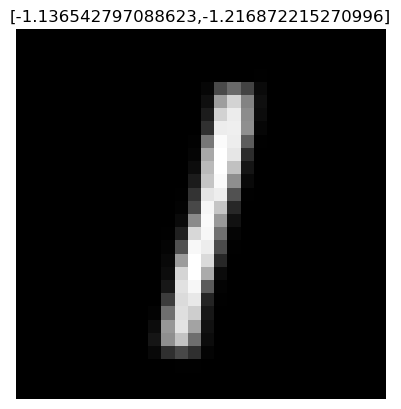

In [28]:
generate_digit_cond(1)

In [29]:
def plot_latent_space_cond(model, digit_class, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample, torch.unsqueeze(torch.tensor([digit_class]), dim=1))
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title("VAE Latent Space Visualization")
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

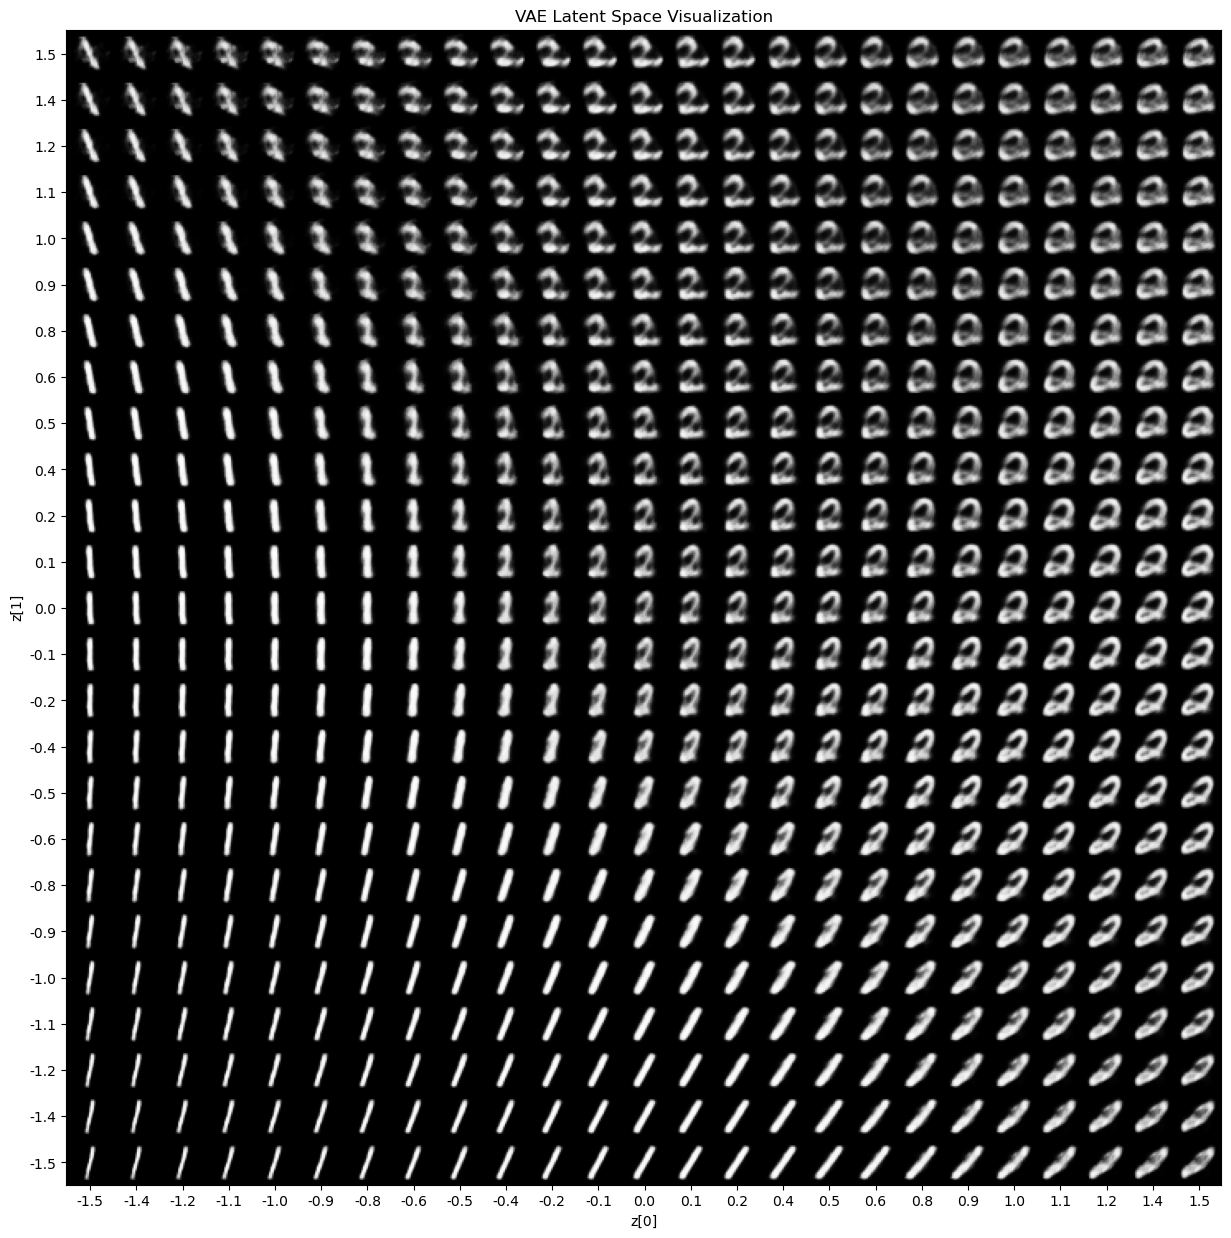

In [30]:
plot_latent_space_cond(model_cond, 1, scale=1.5)